# LTH API Low-level demo
The main purpose of this notebook is to introduce the reader to the low-level part of the LTH API.

We will use the MNIST dataset and a Fully Connected NN to show how things work.

In [1]:
%cd ..

In [2]:
import numpy as np
import tensorflow as tf

from lib.layers import LotteryLinear
from lib.model_base import LotteryModel # Import the LotteryModel class, which constitutes the low-level part of the API

## Data import and preprocessing

In [3]:
# We use the built-in functions in Keras to download and load the MNIST data
(xtr,ytr), (xtest,ytest) = tf.keras.datasets.mnist.load_data()

# We divide by 255 to normalize data to the 0-1 range in order to avoid training problems 
# with the gradient (see exploding gradient, etc.)
xtr = (xtr/255).reshape(xtr.shape[0],-1).astype(np.float32)
xtest = (xtest/255).reshape(xtest.shape[0],-1).astype(np.float32)

## Model initialisation

We make a simple Keras sequential model using the LotteryLinear imported layer as FC layer. 

LotteryLinear takes two parameters: units (int) as neurons and activation (tf.nn.function) as activation function (ReLu by default).

In [4]:
model = tf.keras.Sequential([
    LotteryLinear(units=128),
    LotteryLinear(units=128),
    LotteryLinear(units=10, activation = tf.nn.softmax)
], name="low_level_demo_model")

LotteryModel takes the same parameters as the keras.Model.compile method, in addition to the sequential model structure (model), the data (data) and a experiment name (experiment, optional).

In [5]:
lottmodel = LotteryModel(model=model, data=(xtr,ytr,xtest,ytest), 
                         optimizer="Adam", loss="sparse_categorical_crossentropy", 
                         metrics=["accuracy"], experiment="Low level demo")

When started an instance of the LotteryModel class, the Keras model is compiled and
built and the initial weights are stored in the .initial_weights attribute as a dict.

In a LTH FC model, there are three types of weights: the classical kernel and bias
(trainable) and the mask (non-trainable) which has the mission of pruning the kernel
weights during the process.

The Keras model is accesible through the .network attribute and the model specifications
such as optimizer, loss and metrics list are stored in the .model_specs atr.

## Low-level LTH process
The advantage given by the low-level process is the ability to monitor the pruning and 
have more control over the LTH process by doing it step by step.

1. The first step is training the full network. This is done by using the train method.


In [6]:
lottmodel.train(epochs=10, batch_size=64)

Low level demo: Training Full network
Epoch 1/10
938/938 [==============================] - 4s 4ms/step - loss: 0.2603 - accuracy: 0.9247 - val_loss: 0.1326 - val_accuracy: 0.9590
Epoch 2/10
938/938 [==============================] - 5s 5ms/step - loss: 0.1055 - accuracy: 0.9679 - val_loss: 0.0928 - val_accuracy: 0.9711
Epoch 3/10
938/938 [==============================] - 3s 4ms/step - loss: 0.0713 - accuracy: 0.9779 - val_loss: 0.0937 - val_accuracy: 0.9715
Epoch 4/10
938/938 [==============================] - 3s 4ms/step - loss: 0.0538 - accuracy: 0.9827 - val_loss: 0.0777 - val_accuracy: 0.9767
Epoch 5/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0414 - accuracy: 0.9868 - val_loss: 0.0735 - val_accuracy: 0.9782
Epoch 6/10
938/938 [==============================] - 3s 4ms/step - loss: 0.0326 - accuracy: 0.9894 - val_loss: 0.0874 - val_accuracy: 0.9759
Epoch 7/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0268 - accuracy: 0.9912 - val_loss

We are able to have a visualisation of the weights in each layer through the .plot_weights method, which takes a posiitonal index of the layer whose weights we want to visualise (0 for first layer, etc.).

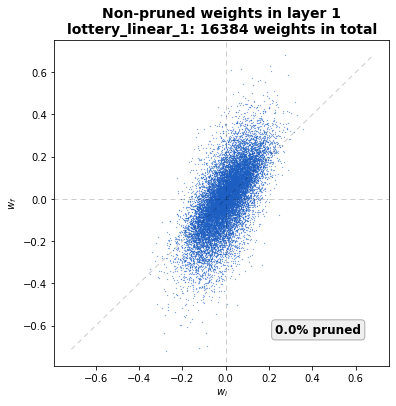

In [7]:
lottmodel.plot_weights(layer=1)

As we can see, a representation of trained weights vs initial weights has an ellipse shape, due to the weights start training from the line y=x.

2. The next step in the LTH process is pruning the weights. This procedure will crop the previous ellipse as we will see. There are several pruning criteria implemented, each of them giving a different cropping shape to the ellipse.
We prune an 80% of the weights in one step, which is known as One-Shot pruning, and the pruning criterion used is "large final", the most common.

In [8]:
lottmodel.prune(prop=0.8, pruning_criterion="lf")

The weight visualisation shows us how this criterion works; it keeps the largest-in-magnitude weights after training.

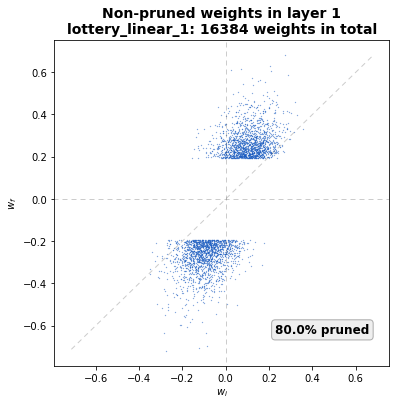

In [9]:
lottmodel.plot_weights(1)

Moreover, a printed pruning summary is also available through the method .pruning_summary. It should be noted that the last layer is pruned at half the rate we input, as it's done in the original LTH paper (see references for reasons).

In [10]:
lottmodel.pruning_summary()

Layer                                 Weights        %Pruned
------------------------------------------------------------
lottery_linear                         100352           80.0

lottery_linear_1                        16384           80.0

lottery_linear_2                         1280           40.0

------------------------------------------------------------
Total                                  118016          79.57


3. After the pruning, we must reinitialise the weights before retraining them. We use the classic rewind method, but there are four other reinit modes available.

In [11]:
lottmodel.reinit(reset_mode="rewind")

We can check the reinit procedure by plotting the weights again. All unpruned weights have returned to their initial values and now the graph shows a straight line corresponding to y=x.

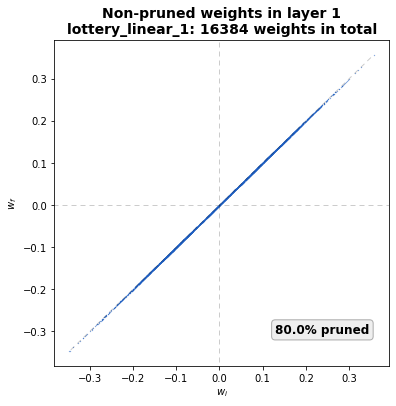

In [12]:
lottmodel.plot_weights(1)

4. Finally, we must retrain the pruned model to check the benefits of the LTH.

In [13]:
lottmodel.train(epochs=10, batch_size=64)

Low level demo: Training 80% Pruned network
Epoch 1/10
938/938 [==============================] - 4s 4ms/step - loss: 0.2698 - accuracy: 0.9409 - val_loss: 0.1015 - val_accuracy: 0.9699
Epoch 2/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0781 - accuracy: 0.9769 - val_loss: 0.0746 - val_accuracy: 0.9771
Epoch 3/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0524 - accuracy: 0.9848 - val_loss: 0.0710 - val_accuracy: 0.9777
Epoch 4/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0393 - accuracy: 0.9883 - val_loss: 0.0746 - val_accuracy: 0.9778
Epoch 5/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0299 - accuracy: 0.9912 - val_loss: 0.0655 - val_accuracy: 0.9813
Epoch 6/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0243 - accuracy: 0.9929 - val_loss: 0.0650 - val_accuracy: 0.9802
Epoch 7/10
938/938 [==============================] - 3s 4ms/step - loss: 0.0187 - accuracy: 0.9949 - va

We can look at the training logs to check the pruned network outperforms the full overparameterized neural network, but it's easier to see a plot containing the learning curves, which can be done through the .plot_learning method.

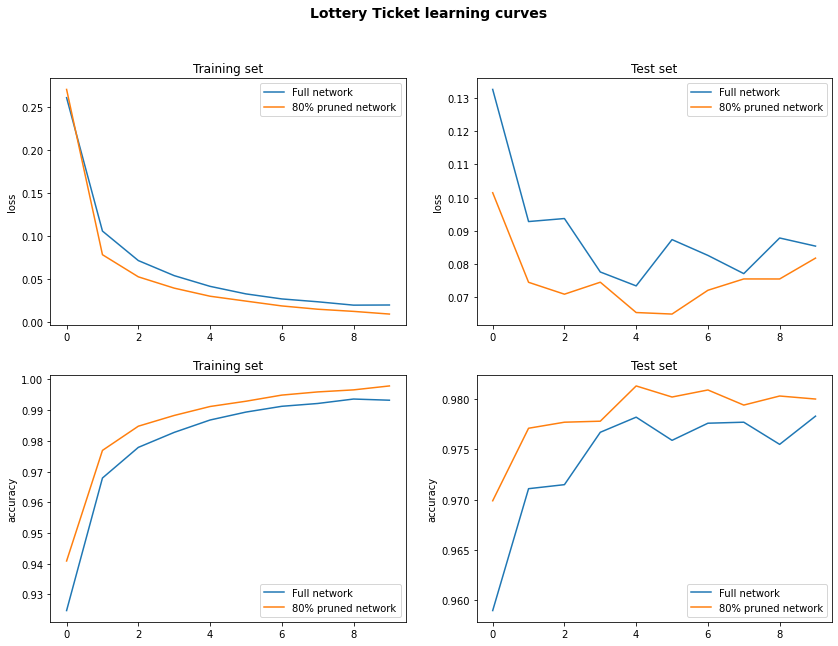

In [14]:
lottmodel.plot_learning()

As we can see, with only a 20% of weights the pruned network obtains better results both in training and test in the first 10 epochs, showing the benefits posed in the Lottery Ticket Hypothesis.